In [1]:
import tqdm
import numpy as np
import scipy.stats
import pandas as pd
import sklearn
from sklearn.feature_selection import mutual_info_regression
import sklearn.covariance
import networkx as nx
import matplotlib.pyplot as plt
% matplotlib inline
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
import seaborn as sns
sns.set_style('ticks')
palette = sns.color_palette("RdBu_r", n_colors=25)
import plotly
plotly.offline.init_notebook_mode(connected=True)

import kliep

In [2]:
def calc_cmi(cov):
    H = np.linalg.slogdet(cov)[1] / 2
    H1 = [np.linalg.slogdet(np.delete(np.delete(cov, [i], axis=0), [i], axis=1))[1] / 2 for i in range(3)]
    H2 = [[np.linalg.slogdet(np.delete(np.delete(cov, [i, j], axis=0), [i, j], axis=1))[1] / 2 for i in range(3)] for j in range(3)]
    cmi = np.array([[H1[i] + H1[j] - (H + H2[i][j]) for i in range(3)] for j in range(3)])
    cmi[np.eye(3, dtype=bool)] = None
    return cmi

In [3]:
pre = [[1,   0.8,    0],
       [0.8,   1, -0.4],
       [0,  -0.4,    1]]
diag = np.sqrt(np.diag(np.linalg.inv(pre)))
pre = pre * diag.reshape(-1, 1) * diag.reshape(1, -1)
cov = np.linalg.inv(pre)
X = scipy.stats.multivariate_normal(mean=[0, 0, 0], cov=cov).rvs(3000)

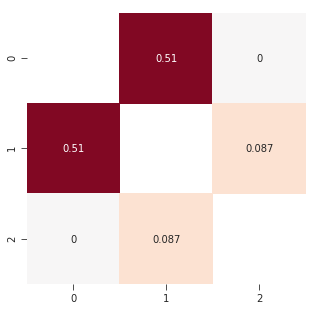

In [4]:
plt.figure(figsize=[5, 5])
sns.heatmap(calc_cmi(cov), annot=True, center=0, cmap=palette, cbar=False)

In [5]:
def mutual_information_knn(X, Y, k=3):
    n_x, d_x = X.shape
    n_y, d_y = Y.shape
    n = n_x
    XY = np.hstack([X, Y])
    knn_xy = sklearn.neighbors.NearestNeighbors(n_neighbors=k+1)
    knn_xy.fit(XY)
    distances, points_xy = knn_xy.kneighbors(XY)
    epsilon_x = np.max(np.linalg.norm(X.reshape([n, -1, d_x]) - X[points_xy], axis=2), axis=1)
    epsilon_y = np.max(np.linalg.norm(Y.reshape([n, -1, d_y]) - Y[points_xy], axis=2), axis=1)
    n_x = np.sum(np.linalg.norm(X.reshape([n_x, -1, d_x]) - X, axis=2) < epsilon_x, axis=1)
    n_y = np.sum(np.linalg.norm(Y.reshape([n_y, -1, d_y]) - Y, axis=2) < epsilon_y, axis=1)
    mi = scipy.special.digamma(k) + scipy.special.digamma(n)
    mi -= 1/k + np.mean(scipy.special.digamma(n_x) + scipy.special.digamma(n_y))
    return mi

In [6]:
tmis = []
cmis = []
cmis_knn3 = []
cmis_knn5 = []
cmis_knn15 = []
for c in tqdm.tqdm(np.arange(0, 1, 0.1)):
    pre = [[1,    c,    0],
           [c,    1, -0.4],
           [0, -0.4,    1]]
    diag = np.sqrt(np.diag(np.linalg.inv(pre)))
    pre = pre * diag.reshape(-1, 1) * diag.reshape(1, -1)
    cov = np.linalg.inv(pre)
    X = scipy.stats.multivariate_normal(mean=[0, 0, 0], cov=cov).rvs(1000)
    
    tmis += [calc_cmi(cov)[0][1]]

    xz = X[:, np.arange(3) != 0]
    y = X[:, [0]]
    z = X[:, (np.arange(3) != 0) & (np.arange(3) != 1)]
    cmis += [kliep.mutual_information(X=xz, Y=y, sigma=1) - kliep.mutual_information(X=y, Y=z, sigma=1)]
    cmis_knn3 += [mutual_information_knn(xz, y, k=3) - mutual_information_knn(y, z, k=3)]
    cmis_knn5 += [mutual_information_knn(xz, y, k=5) - mutual_information_knn(y, z, k=5)]
    cmis_knn15 += [mutual_information_knn(xz, y, k=15) - mutual_information_knn(y, z, k=15)]

100%|██████████| 10/10 [01:31<00:00,  9.25s/it]


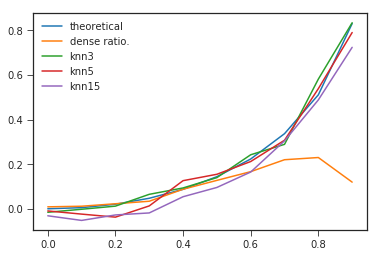

In [7]:
plt.plot(np.arange(0, 1, 0.1), tmis, label='theoretical')
plt.plot(np.arange(0, 1, 0.1), cmis, label='dense ratio.')
plt.plot(np.arange(0, 1, 0.1), cmis_knn3, label='knn3')
plt.plot(np.arange(0, 1, 0.1), cmis_knn5, label='knn5')
plt.plot(np.arange(0, 1, 0.1), cmis_knn15, label='knn15')
plt.legend()

In [16]:
pre = [[   1,  0.5,    0],
       [ 0.5,    1, -0.5],
       [   0, -0.5,    1]]
diag = np.sqrt(np.diag(np.linalg.inv(pre)))
pre = pre * diag.reshape(-1, 1) * diag.reshape(1, -1)
cov = np.linalg.inv(pre)

tmi = calc_cmi(cov)[0][1]
cmis = []
cmis_knn3 = []
cmis_knn5 = []
cmis_knn15 = []
for n in tqdm.tqdm(np.arange(50, 550, 50)):
    X = scipy.stats.multivariate_normal(mean=[0, 0, 0], cov=cov).rvs(n)
    xz = X[:, np.arange(3) != 0]
    y = X[:, [0]]
    z = X[:, (np.arange(3) != 0) & (np.arange(3) != 1)]
    cmis += [kliep.mutual_information(xz, y, sigma=0.8) - kliep.mutual_information(y, z, sigma=0.8)]
    cmis_knn3 += [mutual_information_knn(xz, y, k=3) - mutual_information_knn(y, z, k=3)]
    cmis_knn5 += [mutual_information_knn(xz, y, k=5) - mutual_information_knn(y, z, k=5)]
    cmis_knn15 += [mutual_information_knn(xz, y, k=15) - mutual_information_knn(y, z, k=15)]

100%|██████████| 10/10 [01:09<00:00,  9.02s/it]


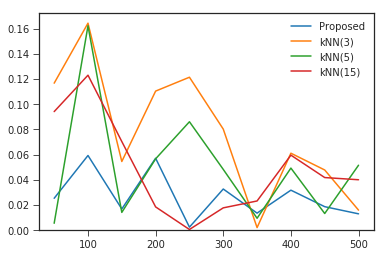

In [17]:
plt.plot(np.arange(50, 550, 50), np.abs(np.array(cmis) - tmi), label='Proposed')
plt.plot(np.arange(50, 550, 50), np.abs(np.array(cmis_knn3) - tmi), label='kNN(3)')
plt.plot(np.arange(50, 550, 50), np.abs(np.array(cmis_knn5) - tmi), label='kNN(5)')
plt.plot(np.arange(50, 550, 50), np.abs(np.array(cmis_knn15) - tmi), label='kNN(15)')
plt.ylim([0, None])
plt.legend()